In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Display Measurement data to obtain column names for future queries
measurement_query = session.query(Measurement).first()
measurement_query.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x217eadaff28>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
# Display Station data to obtain column names for future queries
station_query = session.query(Station).first()
station_query.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x217eadfe438>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

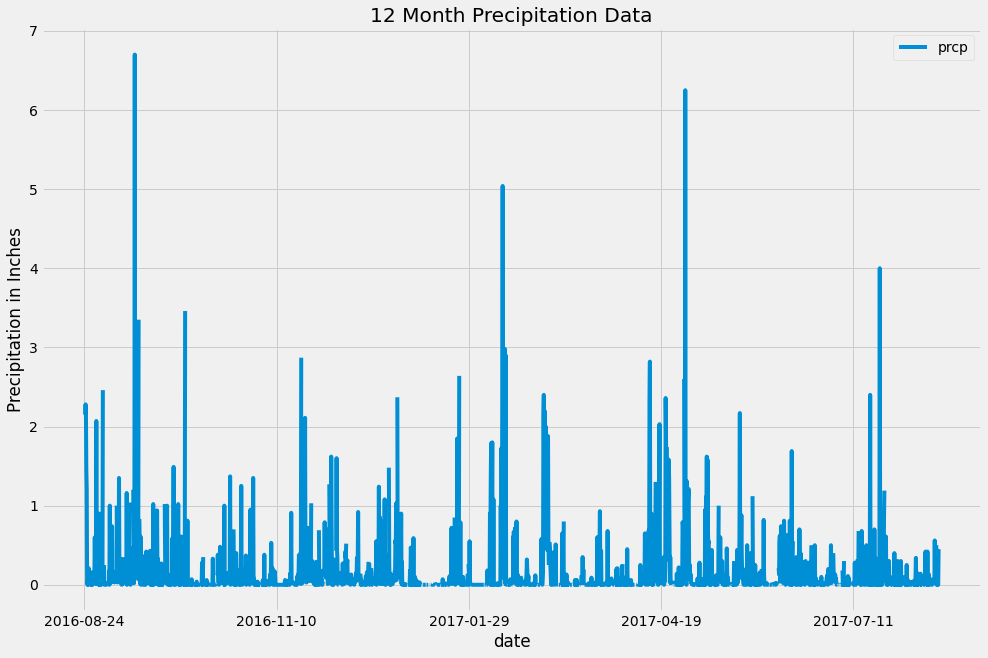

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Create query to find last date in database for next query
recent_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date_query = recent_date_query[0]

# Calculate the date 1 year ago from the last data point in the database
one_year_query = dt.datetime.strptime(recent_date_query, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_query)

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_query, columns=['date', 'prcp'])
precip_df = precip_df.set_index('date')

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind='line', figsize=(15,10), title='12 Month Precipitation Data')
plt.ylabel('Precipitation in Inches')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Station.station).count()
print(f'There are {station_query} stations in dataset')

There are 9 stations in dataset


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station_query = session.query(Measurement.station, func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.station).desc()).all()
print(f'The 9 stations in descending order by count of data points:')
for station, count in active_station_query:
      print(station, count)

The 9 stations in descending order by count of data points:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Set variable for most active station
most_active_station = session.query(Measurement.station)\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count().desc()).first()
(most_active_station, ) = most_active_station
print(f'The most active station is {most_active_station}.')

# min, max, avg temps
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                        .filter(Measurement.station == most_active_station).all()

for min_temp, max_temp, avg_temp in temps:
    print(f'The minimum recorded temperature at station {most_active_station} is {min_temp}.')
    print(f'The maximum recorded temperature at station {most_active_station} is {max_temp}.')
    print(f'The average recorded temperature at station {most_active_station} is {avg_temp}.')

The most active station is USC00519281.
The minimum recorded temperature at station USC00519281 is 54.0.
The maximum recorded temperature at station USC00519281 is 85.0.
The average recorded temperature at station USC00519281 is 71.66378066378067.


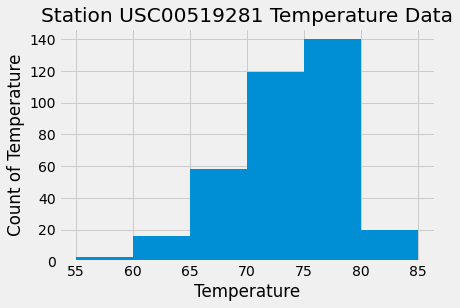

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Recalculate dates for specific station
recent_date_most_active = session.query(Measurement.date)\
                          .filter(Measurement.station == most_active_station)\
                          .order_by(Measurement.date.desc()).first()

recent_date_most_active = recent_date_most_active[0]

twelve_months = dt.datetime.strptime(recent_date_most_active, "%Y-%m-%d") - dt.timedelta(days=365)

most_active_year_temps = session.query(Measurement.tobs)\
                        .filter(Measurement.station == most_active_station)\
                        .filter(Measurement.date >= twelve_months).all()

#Create DF for histogram
temps_df = pd.DataFrame(most_active_year_temps)
temps_df.min()
temps_df.max()

plt.hist(temps_df['tobs'], bins=[55, 60, 65, 70, 75, 80, 85])
plt.title('Station USC00519281 Temperature Data')
plt.xlabel('Temperature')
plt.ylabel('Count of Temperature')
plt.show()

## Bonus Challenge Assignment

Temperature Analysis I

In [18]:
#Hawaii is reputed to enjoy mild weather all year. 
#Is there a meaningful difference between the temperature in, for example, June and December?

#Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.
june_temps = session.query(Measurement.tobs)\
           .filter(func.strftime("%m", Measurement.date) == "06").all()

june_temps = list(np.ravel(june_temps))


dec_temps = session.query(Measurement.tobs)\
           .filter(func.strftime("%m", Measurement.date) == "12").all()

dec_temps = list(np.ravel(dec_temps))


#Use the t-test to determine whether the difference in the means, if any, is statistically significant.
#Using unpaired/independent T-test to compare 2 averages/means of two independent or unrelated groups
stats.ttest_ind(june_temps, dec_temps)

#there is no statistically significant in the means between the average June and December temperatures

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2017-06-12', '2017-06-20'))

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
